In [1]:
import gc
import warnings
import numpy as np
import pandas as pd
import catboost as cb
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    precision_recall_curve,
    roc_auc_score,
    PrecisionRecallDisplay,
    log_loss,
    RocCurveDisplay
)

from intent_model.preprocessing.targets import rh_vs_rest_target

In [2]:
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_parquet('data/dataset_v3/dataset.pq')

In [4]:
data['min_dist_to_known_loc'] /= 100

In [5]:
data.columns

Index(['valid_date', 'ts', 'sessionuuid', 'customer_id', 'booking_id',
       'latitude', 'longitude', 'is_trip_ended', 'quantile', 'weekday',
       'minutes_sin', 'minutes_cos', 'rh', 'norm_week', 'norm_hour',
       'min_dist_to_known_loc', 'known_loc_occ', 'is_freq',
       'dist_to_most_freq', 'rh_frac'],
      dtype='object')

In [6]:
data.head()

,valid_date,ts,sessionuuid,customer_id,booking_id,latitude,longitude,is_trip_ended,quantile,weekday,minutes_sin,minutes_cos,rh,norm_week,norm_hour,min_dist_to_known_loc,known_loc_occ,is_freq,dist_to_most_freq,rh_frac
0,2023-05-23,2023-05-23 08:00:01,502DEA41-AD08-4C0B-9240-9E3840159680,9226442,0,25.160,55.302,0,0.84,2,0.866025,-0.5,0,0.156174,0.000000,0.000870,0.800000,0,0.087006,1.000000
1,2023-05-23,2023-05-23 08:00:01,1669F369-7554-48CF-B3FF-0550B23F5233,55218057,0,25.110,55.178,0,0.93,2,0.866025,-0.5,0,0.555136,0.212000,0.000000,0.741935,0,0.000000,1.000000
2,2023-05-23,2023-05-23 08:00:02,71F539C3-B172-418A-BF31-462229124F63,53665656,0,25.228,55.282,0,0.91,2,0.866025,-0.5,0,0.164957,0.000000,0.000000,0.720000,0,0.000000,1.000000
3,2023-05-23,2023-05-23 08:00:02,c41f4869-1898-4115-b690-b05cc3dafb85,41318473,0,25.202,55.376,0,0.98,2,0.866025,-0.5,0,0.404368,0.112509,0.000036,0.088235,0,0.061205,0.957746
4,2023-05-23,2023-05-23 08:00:03,8F3FBD54-3CF5-4307-ACCD-D641AD03D8E4,43307496,0,25.158,55.403,0,0.80,2,0.866025,-0.5,0,0.486664,0.000000,0.001363,0.416667,0,0.139846,1.000000


In [7]:
data = rh_vs_rest_target(data)

In [8]:
CAT = ['weekday']

TO_DROP = [
    'valid_date', 'ts', 'sessionuuid', 'customer_id', 'booking_id',
    'is_trip_ended', 'rh', 'is_freq', 'target'
]

## Time-based Split

In [9]:
dates = np.sort(data.valid_date.unique())

train = data[data.valid_date.isin(dates[:60])].copy()
val = data[data.valid_date.isin(dates[60:75])].copy()
test = data[data.valid_date.isin(dates[75:])].copy()

In [10]:
train.target.value_counts()

1    4881536
0    1753027
Name: target, dtype: int64

In [11]:
train['sample_weight'] = 1.0
train.loc[(train.rh == 1) & (train.is_trip_ended == 0), 'sample_weight'] = 0.5

In [12]:
train_neg = train[train.target == 0]

train_pos, _ = train_test_split(
    train[train.target == 1],
    test_size=0.5,
    stratify=train[train.target == 1]['sample_weight'],
    random_state=111
)

train = pd.concat([train_neg, train_pos]).sample(frac=1.0).reset_index(drop=True)

In [13]:
train.target.value_counts()

1    2440768
0    1753027
Name: target, dtype: int64

In [14]:
cb_train = cb.Pool(
    train.drop(TO_DROP + ['sample_weight'], axis=1),
    label=train.target.values,
    cat_features=CAT,
    weight=train.sample_weight.values
)

cb_val = cb.Pool(
    val.drop(TO_DROP, axis=1),
    label=val.target.values,
    cat_features=CAT
)

cb_test = test.drop(TO_DROP, axis=1)
cb_test_y = test.target.values

### Model

In [15]:
param = {
    'learning_rate': 0.05,
    'depth': 10,
    'l2_leaf_reg': 4.0,
    'min_child_samples': 1,
    'langevin': True,
    'grow_policy': 'Depthwise',
    'has_time': False,
    'subsample': 0.85
}

param['iterations'] = 750
param['use_best_model'] = True
param['od_type'] = 'Iter'
param['od_wait'] = 50
param['random_state'] = 42
param['bootstrap_type']= 'Bernoulli'
param['score_function'] = 'L2'
param['verbose'] = 50


model = cb.CatBoostClassifier(**param)

model.fit(cb_train, eval_set=cb_val, use_best_model=True, early_stopping_rounds=50)
model.save_model('cb_models/binary_time.cbm')

0:	learn: 0.6689365	test: 0.6672073	best: 0.6672073 (0)	total: 1.36s	remaining: 17m
50:	learn: 0.4702856	test: 0.4506742	best: 0.4506742 (50)	total: 48.7s	remaining: 11m 7s
100:	learn: 0.4612138	test: 0.4432942	best: 0.4432942 (100)	total: 1m 32s	remaining: 9m 52s
150:	learn: 0.4555711	test: 0.4395291	best: 0.4395291 (150)	total: 2m 12s	remaining: 8m 43s
200:	learn: 0.4518903	test: 0.4374076	best: 0.4374076 (200)	total: 2m 50s	remaining: 7m 44s
250:	learn: 0.4486431	test: 0.4356643	best: 0.4356643 (250)	total: 3m 28s	remaining: 6m 53s
300:	learn: 0.4455661	test: 0.4341250	best: 0.4341250 (300)	total: 4m 5s	remaining: 6m 6s
350:	learn: 0.4419491	test: 0.4326918	best: 0.4326918 (350)	total: 4m 42s	remaining: 5m 21s
400:	learn: 0.4383853	test: 0.4314286	best: 0.4314286 (400)	total: 5m 19s	remaining: 4m 37s
450:	learn: 0.4350108	test: 0.4302852	best: 0.4302852 (450)	total: 5m 56s	remaining: 3m 56s
500:	learn: 0.4319356	test: 0.4293046	best: 0.4293046 (500)	total: 6m 32s	remaining: 3m 15s
5

In [16]:
ppreds = model.predict_proba(cb_test)
preds = model.predict(cb_test)

### Evaluation

In [17]:
from intent_model.functions import get_optimal_threshold

In [18]:
log_loss(cb_test_y, ppreds)

0.4274513902681196

In [19]:
roc_auc_score(cb_test_y, ppreds[:, 1])

0.8666950941422817

In [20]:
print(classification_report(cb_test_y, preds))

              precision    recall  f1-score   support

           0       0.63      0.75      0.68    486594
           1       0.89      0.83      0.86   1238338

    accuracy                           0.80   1724932
   macro avg       0.76      0.79      0.77   1724932
weighted avg       0.82      0.80      0.81   1724932



In [21]:
dict(zip(model.feature_names_, model.get_feature_importance()))

{'latitude': 5.361521461060319,
 'longitude': 4.733216182159135,
 'quantile': 3.447642757017909,
 'weekday': 1.233233683551941,
 'minutes_sin': 3.4282952917007408,
 'minutes_cos': 7.7854858801125735,
 'norm_week': 2.727400874083827,
 'norm_hour': 2.2320993851582904,
 'min_dist_to_known_loc': 2.3327190511024645,
 'known_loc_occ': 2.5339150881939365,
 'dist_to_most_freq': 5.355695882370784,
 'rh_frac': 58.82877446348807}

In [22]:
target_thresh, expected_recall = get_optimal_threshold(cb_test_y, ppreds[:, 1], 0.9)

print(target_thresh)
print(expected_recall)

0.5335348888873943
0.8066892883849159


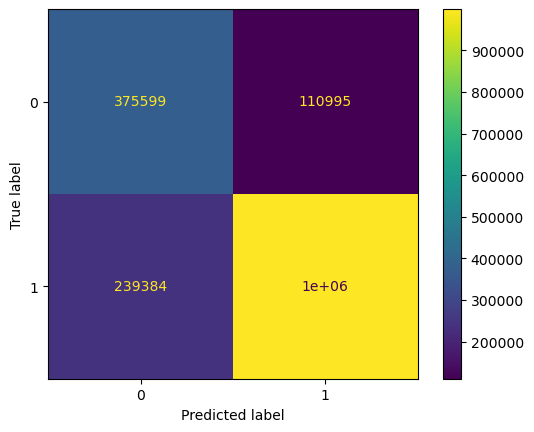

In [23]:
threshold = target_thresh

cm = confusion_matrix(cb_test_y, np.where(ppreds[:, 1] > threshold, 1, 0))
cm_display = ConfusionMatrixDisplay(cm).plot()

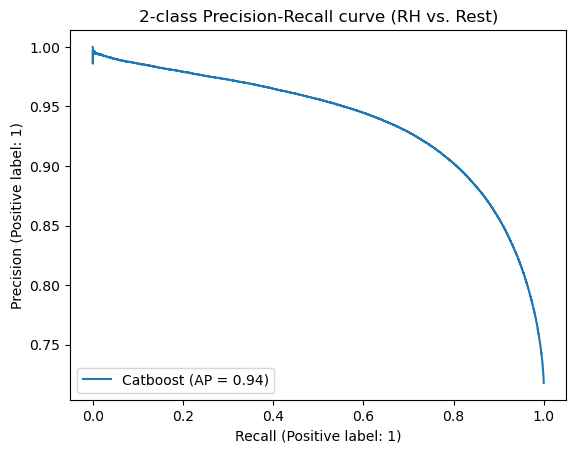

In [24]:
display = PrecisionRecallDisplay.from_predictions(cb_test_y, ppreds[:, 1], name="Catboost")
_ = display.ax_.set_title("2-class Precision-Recall curve (RH vs. Rest)")

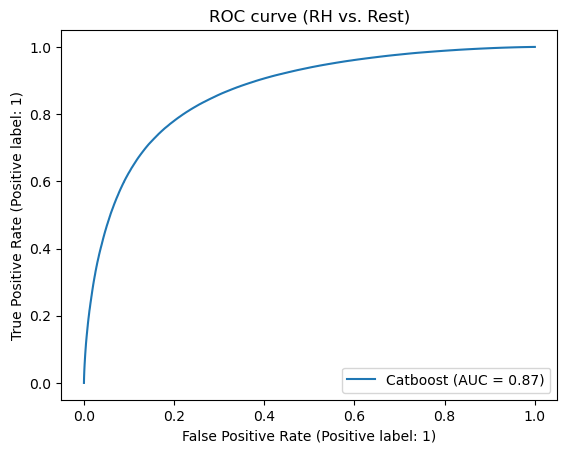

In [25]:
display = RocCurveDisplay.from_predictions(cb_test_y, ppreds[:, 1], name="Catboost")
_ = display.ax_.set_title("ROC curve (RH vs. Rest)")

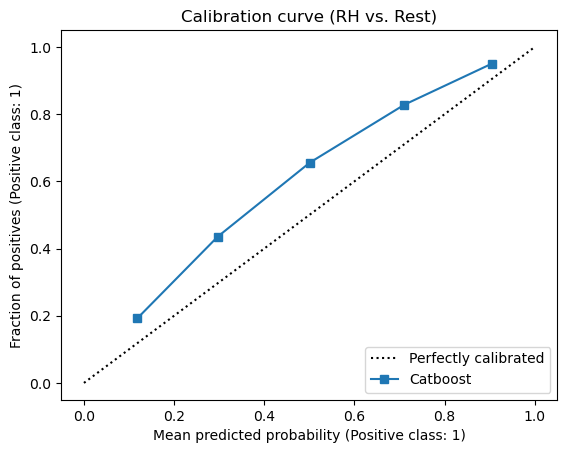

In [26]:
display = CalibrationDisplay.from_predictions(cb_test_y, ppreds[:, 1], name="Catboost")
_ = display.ax_.set_title("Calibration curve (RH vs. Rest)")

### Additional Sanity Check

In [27]:
from intent_model.functions import get_conversions

In [28]:
res_df = get_conversions(test, cb_test, model)

res_df

100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.25it/s]


,threshold,sa_coverage,rh_coverage,relevance
0,0.4,0.728368,0.880521,0.573454
1,0.5,0.664699,0.826543,0.596377
2,0.6,0.599309,0.762620,0.617269
3,0.7,0.523618,0.679964,0.638440
4,0.8,0.419284,0.554939,0.668424
5,0.9,0.236568,0.320019,0.745478


In [29]:
gc.collect()

6995

## User-based Split

In [30]:
users = data.customer_id.unique()
n = len(users)

train = data[data.customer_id.isin(users[:int(0.5*n)])].copy()
val = data[data.customer_id.isin(users[int(0.5*n):int(0.75*n)])].copy()
test = data[data.customer_id.isin(users[int(0.75*n):])].copy()

In [31]:
print(len(train))
print(len(val))
print(len(test))

6196427
1351348
2541822


In [32]:
train.target.value_counts()

1    4571784
0    1624643
Name: target, dtype: int64

In [33]:
val.target.value_counts()

1    1017350
0     333998
Name: target, dtype: int64

In [34]:
test.target.value_counts()

1    1789857
0     751965
Name: target, dtype: int64

In [35]:
train['sample_weight'] = 1.0
train.loc[(train.rh == 1) & (train.is_trip_ended == 0), 'sample_weight'] = 0.5

In [36]:
train_neg = train[train.target == 0]

train_pos, _ = train_test_split(
    train[train.target == 1],
    test_size=0.5,
    stratify=train[train.target == 1]['sample_weight'],
    random_state=111
)

train = pd.concat([train_neg, train_pos]).sample(frac=1.0).reset_index(drop=True)

In [37]:
train.target.value_counts()

1    2285892
0    1624643
Name: target, dtype: int64

In [38]:
cb_train = cb.Pool(
    train.drop(TO_DROP + ['sample_weight'], axis=1),
    label=train.target.values,
    cat_features=CAT,
    weight=train.sample_weight.values
)

cb_val = cb.Pool(
    val.drop(TO_DROP, axis=1),
    label=val.target.values,
    cat_features=CAT
)

cb_test = test.drop(TO_DROP, axis=1)
cb_test_y = test.target.values

### Model

In [39]:
param = {
    'learning_rate': 0.05,
    'depth': 10,
    'l2_leaf_reg': 4.0,
    'min_child_samples': 1,
    'langevin': True,
    'grow_policy': 'Depthwise',
    'has_time': False,
    'subsample': 0.85
}

param['iterations'] = 750
param['use_best_model'] = True
param['od_type'] = 'Iter'
param['od_wait'] = 50
param['random_state'] = 42
param['bootstrap_type']= 'Bernoulli'
param['score_function'] = 'L2'
param['verbose'] = 50


u_model = cb.CatBoostClassifier(**param)

u_model.fit(cb_train, eval_set=cb_val, use_best_model=True, early_stopping_rounds=50)
u_model.save_model('cb_models/binary_user.cbm')

0:	learn: 0.6670855	test: 0.6680359	best: 0.6680359 (0)	total: 1.23s	remaining: 15m 19s
50:	learn: 0.4566192	test: 0.4543129	best: 0.4543129 (50)	total: 45s	remaining: 10m 16s
100:	learn: 0.4471687	test: 0.4502584	best: 0.4502584 (100)	total: 1m 25s	remaining: 9m 12s
150:	learn: 0.4412687	test: 0.4482215	best: 0.4482215 (150)	total: 2m 3s	remaining: 8m 9s
200:	learn: 0.4363700	test: 0.4461501	best: 0.4461501 (200)	total: 2m 38s	remaining: 7m 12s
250:	learn: 0.4327648	test: 0.4447613	best: 0.4447613 (250)	total: 3m 14s	remaining: 6m 25s
300:	learn: 0.4292365	test: 0.4435274	best: 0.4435274 (300)	total: 3m 49s	remaining: 5m 43s
350:	learn: 0.4254299	test: 0.4423629	best: 0.4423629 (350)	total: 4m 23s	remaining: 5m
400:	learn: 0.4218995	test: 0.4415298	best: 0.4415298 (400)	total: 4m 57s	remaining: 4m 19s
450:	learn: 0.4185837	test: 0.4407502	best: 0.4407502 (450)	total: 5m 31s	remaining: 3m 39s
500:	learn: 0.4150226	test: 0.4398633	best: 0.4398633 (500)	total: 6m 6s	remaining: 3m 2s
550:

In [40]:
u_ppreds = u_model.predict_proba(cb_test)
u_preds = u_model.predict(cb_test)

### Evaluation

In [41]:
log_loss(cb_test_y, u_ppreds)

0.48122902823197505

In [42]:
roc_auc_score(cb_test_y, u_ppreds[:, 1])

0.8189949362100647

In [43]:
print(classification_report(cb_test_y, u_preds))

              precision    recall  f1-score   support

           0       0.61      0.64      0.63    751965
           1       0.85      0.83      0.84   1789857

    accuracy                           0.77   2541822
   macro avg       0.73      0.73      0.73   2541822
weighted avg       0.78      0.77      0.78   2541822



In [44]:
dict(zip(u_model.feature_names_, u_model.get_feature_importance()))

{'latitude': 4.60442089124777,
 'longitude': 4.52319613866467,
 'quantile': 3.1845803763339804,
 'weekday': 1.554781214966519,
 'minutes_sin': 2.942587149213016,
 'minutes_cos': 7.798385748720093,
 'norm_week': 2.7714372735262267,
 'norm_hour': 1.9482153193294307,
 'min_dist_to_known_loc': 2.378949166729688,
 'known_loc_occ': 2.43113484146206,
 'dist_to_most_freq': 4.560924067222278,
 'rh_frac': 61.301387812584274}

In [45]:
target_thresh, expected_recall = get_optimal_threshold(cb_test_y, u_ppreds[:, 1], 0.9)

print(target_thresh)
print(expected_recall)

0.7130031112763732
0.6358787322115678


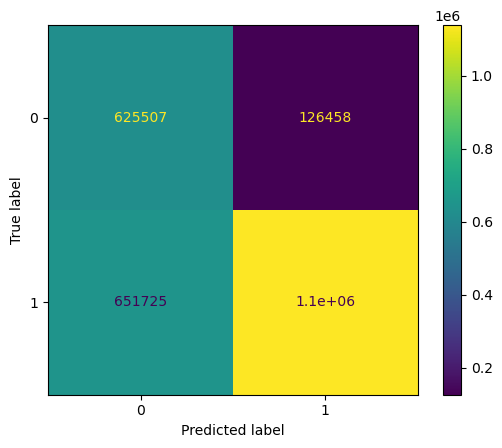

In [46]:
threshold = target_thresh

cm = confusion_matrix(cb_test_y, np.where(u_ppreds[:, 1] > threshold, 1, 0))
cm_display = ConfusionMatrixDisplay(cm).plot()

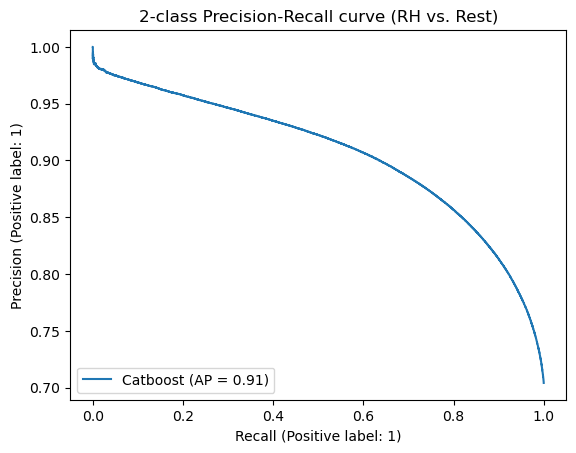

In [47]:
display = PrecisionRecallDisplay.from_predictions(cb_test_y, u_ppreds[:, 1], name="Catboost")
_ = display.ax_.set_title("2-class Precision-Recall curve (RH vs. Rest)")

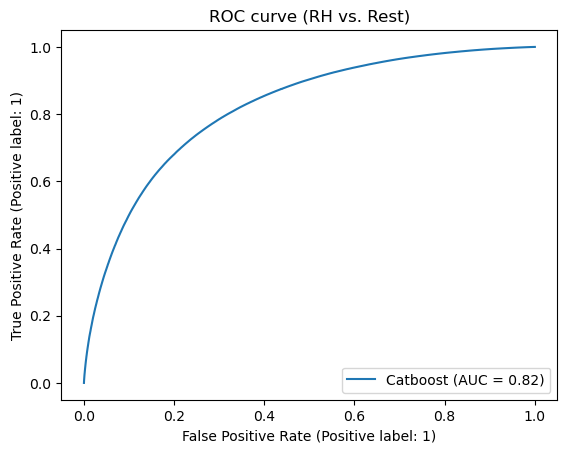

In [48]:
display = RocCurveDisplay.from_predictions(cb_test_y, u_ppreds[:, 1], name="Catboost")
_ = display.ax_.set_title("ROC curve (RH vs. Rest)")

#### "Bad" users

In [49]:
test['preds'] = u_ppreds[:, 1]
test['loss'] = -(test['target'] * np.log(test['preds']) + (1 - test['target'])*np.log(1 - test['preds']))

test_g = test[['customer_id', 'loss']].groupby('customer_id', as_index=False).mean()\
    .sort_values('loss', ascending=False)

test_g.head(10)

,customer_id,loss
58029,56479445,3.816590
51925,52932478,3.706679
37998,43395141,3.572993
37650,42980355,3.570523
36770,41906030,3.496867
56126,55394198,3.320927
6763,6240853,3.254623
63052,58859635,3.141520
61932,58404859,3.133453
35568,40695268,3.117883


<AxesSubplot: ylabel='Density'>

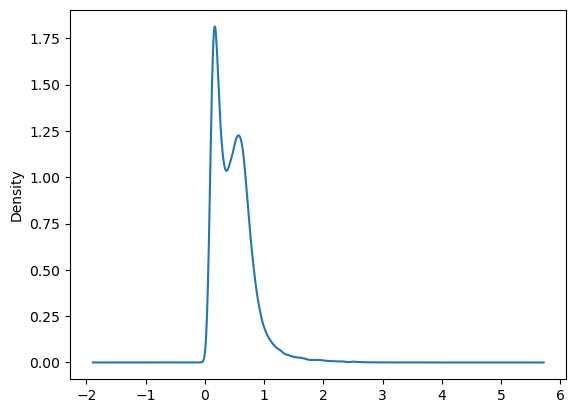

In [50]:
test_g.loss.plot(kind='kde')

In [51]:
val['preds'] = u_model.predict_proba(cb_val)[:, 1]
val['loss'] = -(val['target'] * np.log(val['preds']) + (1 - val['target'])*np.log(1 - val['preds']))

val_g = val[['customer_id', 'loss']].groupby('customer_id', as_index=False).mean()\
    .sort_values('loss', ascending=False)

val_g.head(10)

,customer_id,loss
21015,44733992,3.452492
65454,61810743,3.424535
2481,2598184,3.298346
39877,54675153,3.227494
28498,49800416,3.144417
64903,61706007,3.117313
26375,48296307,3.103640
36280,53323263,3.063237
4614,7537300,3.061168
53239,58991241,2.916689


<AxesSubplot: ylabel='Density'>

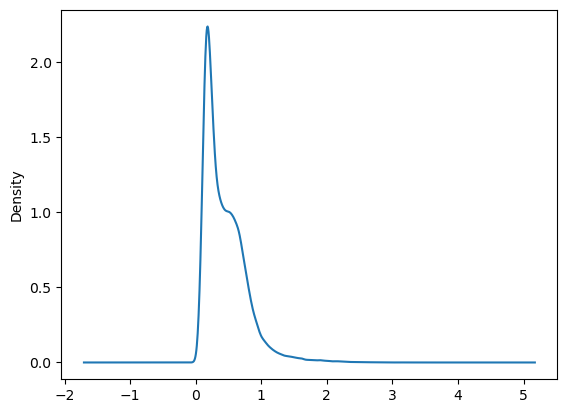

In [52]:
val_g.loss.plot(kind='kde')

In [53]:
train['preds'] = u_model.predict_proba(cb_train)[:, 1]
train['loss'] = -(train['target'] * np.log(train['preds']) + (1 - train['target'])*np.log(1 - train['preds']))

train_g = train[['customer_id', 'loss']].groupby('customer_id', as_index=False).mean()\
    .sort_values('loss', ascending=False)

train_g.head(10)

,customer_id,loss
122881,58748436,3.658791
129841,59407153,3.612654
14534,14027070,2.988153
81922,52682949,2.983386
24327,29274565,2.978599
59192,47136634,2.957710
136058,60104648,2.915993
5975,2696280,2.893580
26852,32227799,2.866438
17837,19059622,2.851659


<AxesSubplot: ylabel='Density'>

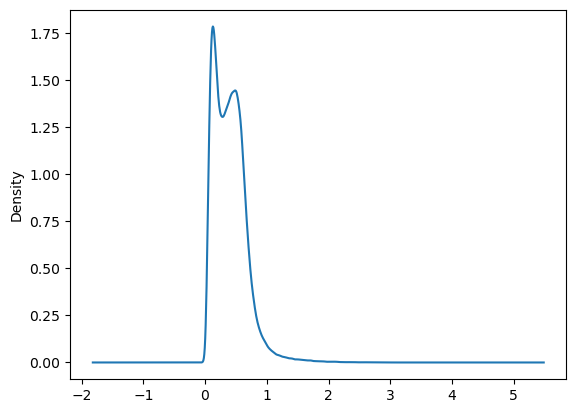

In [54]:
train_g.loss.plot(kind='kde')

### Additional Sanity Check

In [55]:
res_df = get_conversions(test, cb_test, u_model)

res_df

100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.39it/s]


,threshold,sa_coverage,rh_coverage,relevance
0,0.4,0.762981,0.888134,0.543921
1,0.5,0.692055,0.830800,0.566437
2,0.6,0.611229,0.755721,0.589456
3,0.7,0.512375,0.652380,0.614645
4,0.8,0.377945,0.495435,0.647122
5,0.9,0.174153,0.235783,0.715264


In [56]:
gc.collect()

12611